# Clustering
Our first unsupervised machine learning technique is clustering. Clustering groups data points together based on their similarity. The goal is to identify natural groupings or clusters within (unlabeled) data that can provide insights into the underlying structure or patterns. Two commonly used clustering algorithms are k-means clustering and DBSCAN.

## K-means clustering
K-means clustering partitions the data into $k$ clusters based on each observation's distance to $k$ centroids. The algorithm works by first randomly assigning $k$ initial cluster centroids, and then iteratively reassigning data points to the nearest centroid until the centroids no longer change. K-means is simple and computationally efficient, making it suitable for large datasets with a small number of clusters.

We will perform k-means clustering on artificial data by generating 3 "blobs". Artificial or empirical, we should normalize our data. One way is to scale and translate the data such that each feature has zero mean and unit variance. The reason is because clustering is very sensitive to the distance between data vectors. If the data is unscaled, the clustering algorithm may be disproportionately sensitive to some of the features. 

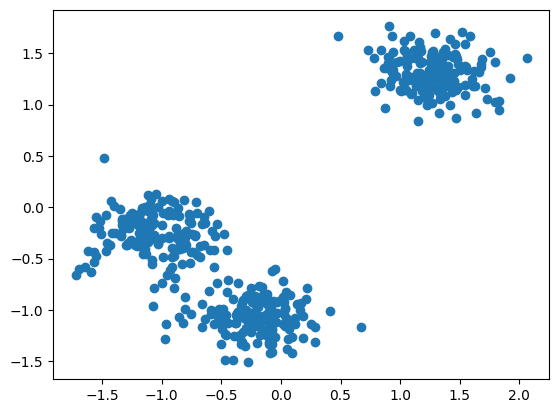

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs, make_moons

# Make artificial data on 3 blobs
blob, _ = make_blobs(n_samples=500, centers=3, random_state=1)

# Normalize data
scaler = StandardScaler()
blob = scaler.fit_transform(blob)

# Plot
plt.scatter(blob[:, 0], blob[:, 1])
plt.show()

The overall k-means clustering procedure is as follows:
1. Initialize $k$ centroids by placing them at the location of $k$ arbitrarily selected data vectors.
2. Repeat until the data points' cluster assignments do not change after an iteration.
    1. For each data vector, assign it to the cluster associated with the nearest centroid.
    2. For each centroid, redesignate its location as the mean of the data vectors in the associated cluster.

In [2]:
def k_means_clustering(data, k):
    '''
    Performs k-means clustering.
    INPUT
        data; (n, m)-shape numpy array, representing n data observations on m features
        k; number of centroid clusters
    RETURNS
        (n, )-shape numpy series, where the ith entry is the cluster assigned to data point i
    '''
    # Initialize location of centroids
    centroids = data[random.sample(range(data.shape[0]), k), :]
    
    # This vector stores the cluster associated with each data observation
    assignment = np.zeros(data.shape[0], dtype=int)
    
    # Loop until convergence
    while True:
        
        # Tracks whether a data point changes cluster assignment this iteration
        convergence_flag = True
        
        # Tracks the size of each cluster this iteration
        cluster_size = np.zeros(k)
        
        # Tracks the total sum of the data vectors assigned to each cluster this iteration
        centroid_net_vector = np.zeros(centroids.shape)
        
        # Assign each data point to nearest cluster
        for ind in range(data.shape[0]):
            
            # Compute distance between data point and each cluster
            distances = np.linalg.norm(centroids - data[ind, :], axis=1)
            
            # Assign data point to nearest cluster
            new_cluster = np.argmin(distances)
            if new_cluster != assignment[ind]:
                assignment[ind] = new_cluster
                convergence_flag = False
                
            # Record the data vector's assignment to this cluster
            cluster_size[new_cluster] += 1
            centroid_net_vector[new_cluster] += data[ind, :]
        
        # If no data vector changed cluster assignment, then return
        if convergence_flag:
            return assignment
        
        # Compute new centroid clusters
        for cluster in range(k):
            centroids[cluster, :] = centroid_net_vector[cluster, :] / cluster_size[cluster]

Let's perform k-means clustering on our blob dataset. We will try clustering for varying values of $k$ to see how the algorithm performs for varying numbers of clusters.

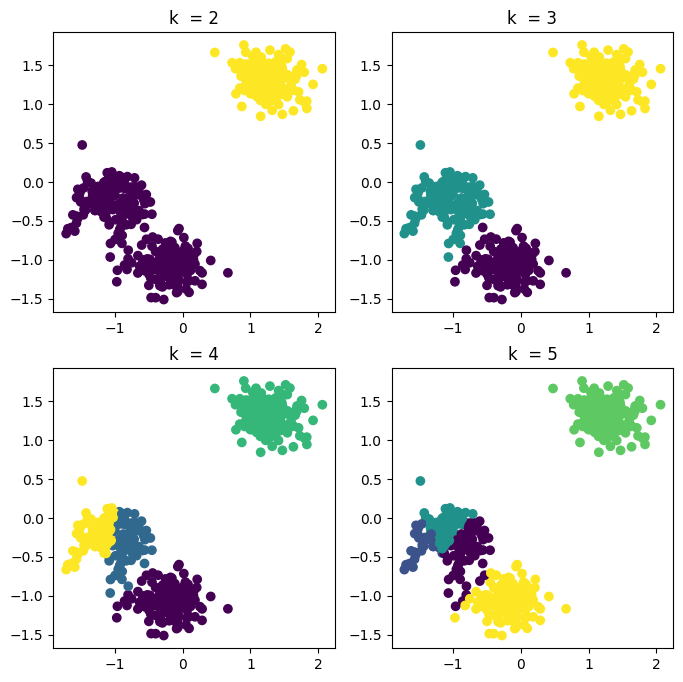

In [3]:
# Create subplots of each tested k cluster count
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(8, 8))

# Loop through each tested k cluster count
for ind, k in enumerate(range(2, 6)):
    
    # Perform k-means clustering
    assignment = k_means_clustering(blob, k)
    
    # Create subplot
    ax = plt.subplot(gs[int(ind / 2), ind % 2])
    fig = plt.scatter(blob[:, 0], blob[:, 1], c=assignment)
    ax.set_title("k  = " + str(k))

Observe that the clustering is quite sensitive to $k$. Visual inspection shows that $k=3$ performs best; this is expected because the artificial data was generating on 3 blobs.

While k-means clustering is effective at grouping together data in a balanced "blob" shape, k-means clustering fails for irregularly shaped clusters. See below for such an example of how k-means clustering can fail.

To capture irregularly shaped clusters, we need to use DBSCAN.

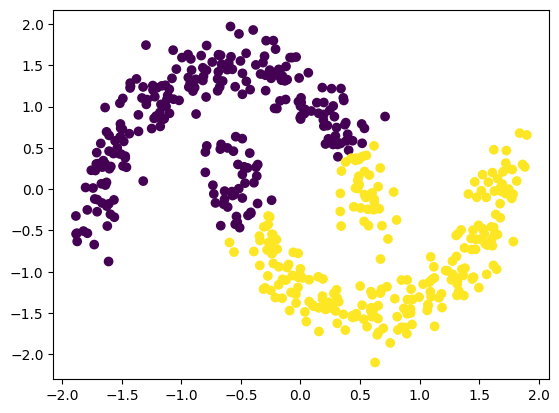

In [4]:
# Make irregularly shaped artificial data
moon, _ = make_moons(n_samples=500, noise=0.1, random_state=0)

# Normalize data
moon = scaler.fit_transform(moon)

# Cluster on k=2
assignment = k_means_clustering(moon, 2)

# Plot
plt.scatter(moon[:, 0], moon[:, 1], c=assignment)
plt.show()

## Density-based spatial clustering of applications with noise (DBSCAN)
DBSCAN is a density-based clustering algorithm that groups together data points that are in dense regions and separates out points that are in sparse regions. The algorithm defines a density threshold and a distance threshold. DBSCAN groups together data points that are within a distance threshold to each other if the number of nearby data points meets the density threshold.

Formally, for pre-defined density threshold $N$ and distance threshold $\epsilon$:
1. For each data point, designate the data point as an "interior" data point if it is within $\epsilon$ distance to at least $N$ other data points.
2. Connect each pair of interior data point that are within $\epsilon$ distance of each other.
3. Cluster interior data points that are part of the same connected component.
4. For each noninterior data point, assign it a cluster that is within $\epsilon$ distance. If no such cluster exists, designate it as noise.

Our implementation below comes from the [pseudocode from Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#Algorithm). Observe similarities to [depth-first-search](https://en.wikipedia.org/wiki/Depth-first_search).

In [5]:
def dbscan(data, distance_threshold, density_threshold):
    '''
    Performs DBSCAN clustering.
    INPUT
        data; (n, m)-shape numpy array, representing n data observations on m features
        distance_threshold; distance at which to find neighborhood of data points
        density_threshold; minimum number of neighboring data points for interior points
    RETURNS
        (n, )-shape numpy series, where the ith entry is the cluster assigned to data point i
    '''
    # Tracks the current cluster index (starts at 1). Cluster 0 is noise.
    cluster = 1
    
    # This vector stores the cluster associated with each data observation.
    # 0 represents noise.
    # -1 represents data points that have yet to be evaluated.  
    assignment = -np.ones(data.shape[0], dtype=int)
    
    # For each data point, if it has not yet been clustered, determine if it is an interior point.
    # If it is an interior point, augment the cluster with its neighbors.
    for ind in range(data.shape[0]):
        
        # If data point has already been evaluated, continue
        if assignment[ind] != -1:
            continue
            
        # If data point is not an interior point, mark as noise.
        # (Later iterations may change label to an noninterior point in a cluster.)
        neighbors = find_neighbors(data, data[ind, :], distance_threshold)
        if len(neighbors) < density_threshold:
            assignment[ind] = 0
            continue
            
        # The data point is an interior point. Assign to the current cluster.
        assignment[ind] = cluster
        
        # Augment the current cluster from this points neighbors.
        while neighbors:
            
            # Get one of the neighbors
            nbr_ind = neighbors.pop()
            
            # If the neighbor is noise, assign it to the current cluster
            if assignment[nbr_ind] == 0:
                assignment[nbr_ind] = cluster
                continue
                
            # If the neighbor has already been assigned to a cluster, continue
            if assignment[nbr_ind] >= 1:
                continue
            
            # Assign to the current cluster
            assignment[nbr_ind] = cluster
            
            # If the neighbor is an interior point, augment the current cluster from this neighbor's neighbor
            new_neighbors = find_neighbors(data, data[nbr_ind, :], distance_threshold)
            if len(new_neighbors) >= density_threshold:
                for new_nbr_ind in new_neighbors:
                    
                    # Only evaluate new points that haven't already been assigned to a cluster
                    if assignment[new_nbr_ind] <= 0:
                        neighbors.append(new_nbr_ind)
        
        # Increment to the next cluster
        cluster += 1
        
    return assignment
                
        
def find_neighbors(data, vector, distance_threshold):
    '''
    Finds indices of all data points within given distance to a given vector.
    INPUT
        data; (n, m)-shape numpy array, representing n data observations on m features
        vector; (m, )-shape numpy series representing one data vector
        distance_threshold; distance to search for neighbors
    RETURNS
        list of indices of rows of data that are within distances_threshold of vector
    '''
    distances = np.linalg.norm(data - vector, axis=1)
    return [ind for ind in range(len(distances)) if distances[ind] < distance_threshold]

Let's perform DBSCAN on our moons data. Again, let's test the algorithm's sensitivity to the input distance and density threshold parameters.

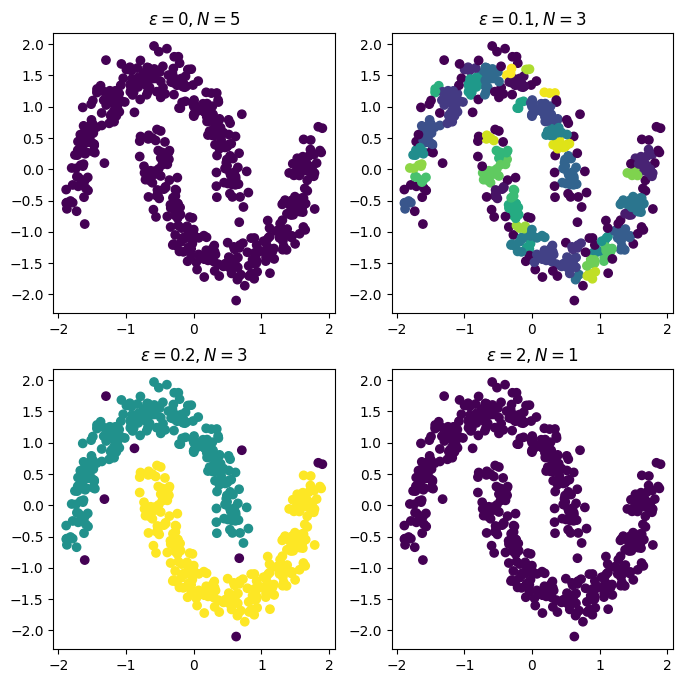

In [6]:
# Distance and density threshold parameters to test
distance_thresholds = [0, 0.1, 0.2, 2]
density_thresholds = [5, 3, 3, 1]

# Create subplots of each tested k cluster count
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(8, 8))

# Loop through each tested k cluster count
for ind in range(4):
    
    dist = distance_thresholds[ind]
    dens = density_thresholds[ind]
    
    # Perform k-means clustering
    assignment = dbscan(moon, dist, dens)
    
    # Create subplot
    ax = plt.subplot(gs[int(ind / 2), ind % 2])
    fig = plt.scatter(moon[:, 0], moon[:, 1], c=assignment)
    ax.set_title("$\epsilon = " + str(dist) + ", N = " + str(dens) + "$")

DBSCAN is very sensitive to the input parameters. If $\epsilon$ is too low or $N$ is too high, then it is impossible for a data point to qualify as an interior point, and all data points are marked as noise. If $\epsilon$ is too high or $N$ is too low, then all data points quality as interior points of the same cluster. A lot of manual fine-tuning is required to find reasonable values for $\epsilon, N$. For our experiment, $\epsilon = 0.2, N = 3$ properly clusters both moons, with some slight noise.

In conclusion, we have explored two clustering technqiues: k-means clustering and DBSCAN. K-means clustering is simpler to implement and has more interpretable parameters. DBSCAN is more flexible and can capture irregularly shaped data.